In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-lwhnfq0w
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-lwhnfq0w
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=c0ca2696fddd1399f0edb21121effa30cb93573995c1c451cda22f20357553eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-etvqxdac/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.getcwd()
os.chdir('/content/drive/My Drive')

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['s01','s02','s03']
#List of subjects

In [ ]:

def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/MyDrive/eeg dataset/" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))
                start = start + step_size

        meta = np.array(meta)
        np.save('/content/drive/MyDrive/eeg dataset' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/MyDrive/eeg dataset' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (46848, 70) (46848, 4)
testing dataset: (11712, 70) (11712, 4)


In [ ]:
with open('/content/drive/My Drive/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open('/content/drive/My Drive/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [ ]:
X.shape

(46848, 70)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_train.shape

(46848, 10)

In [ ]:
x_train = np.array(X[:])

In [ ]:
with open('/content/drive/My Drive/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open('/content/drive/My Drive/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(46848, 70, 1)

In [ ]:
batch_size = 256
num_classes = 8
epochs = 200
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(70, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 128)           512       
                                                                 
 batch_normalization (BatchN  (None, 70, 128)          512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 35, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 128)           49280     
                                                                 
 batch_normalization_1 (Batc  (None, 35, 128)          512       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/200
183/183 [==============================] - 31s 163ms/step - loss: 1.6727 - accuracy: 0.3243 - val_loss: 1.7416 - val_accuracy: 0.1835
Epoch 2/200
183/183 [==============================] - 31s 167ms/step - loss: 1.4733 - accuracy: 0.3990 - val_loss: 1.4774 - val_accuracy: 0.3764
Epoch 3/200
183/183 [==============================] - 32s 173ms/step - loss: 1.3608 - accuracy: 0.4498 - val_loss: 1.1996 - val_accuracy: 0.5067
Epoch 4/200
183/183 [==============================] - 32s 177ms/step - loss: 1.2575 - accuracy: 0.4923 - val_loss: 1.1077 - val_accuracy: 0.5411
Epoch 5/200
183/183 [==============================] - 30s 164ms/step - loss: 1.1847 - accuracy: 0.5184 - val_loss: 1.0456 - val_accuracy: 0.5699
Epoch 6/200
183/183 [==============================] - 30s 164ms/step - loss: 1.1156 - accuracy: 0.5510 - val_loss: 0.9735 - val_accuracy: 0.5999
Epoch 7/200
183/183 [==============================] - 32s 174ms/step - loss: 1.0563 - accuracy: 0.5741 - val_loss: 0.9470 -

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

366/366 [==============================] - 3s 7ms/step - loss: 0.4522 - accuracy: 0.8812
Test loss: 0.4522206485271454
Test accuracy: 0.8812329173088074


In [ ]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


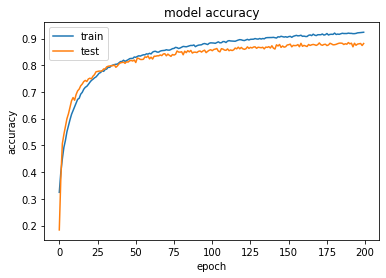

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

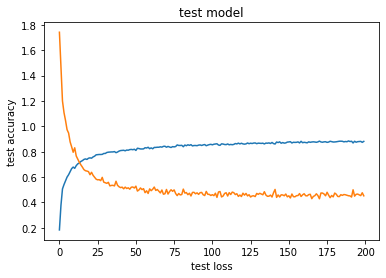

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

In [ ]:
y_pred=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
y_pred[1]

array([8.7993164e-36, 2.0060172e-07, 2.3664955e-38, 1.7161075e-07,
       7.6483606e-14, 1.4743505e-05, 1.9133868e-05, 9.9996400e-01,
       5.1853704e-07, 1.3269774e-06], dtype=float32)

In [ ]:
y_test1=np.argmax(y_test, axis=1)

In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
y_test1[1]

7

In [ ]:
y_pred[1]

7

In [ ]:
cmatrix=confusion_matrix(y_test1, y_pred)

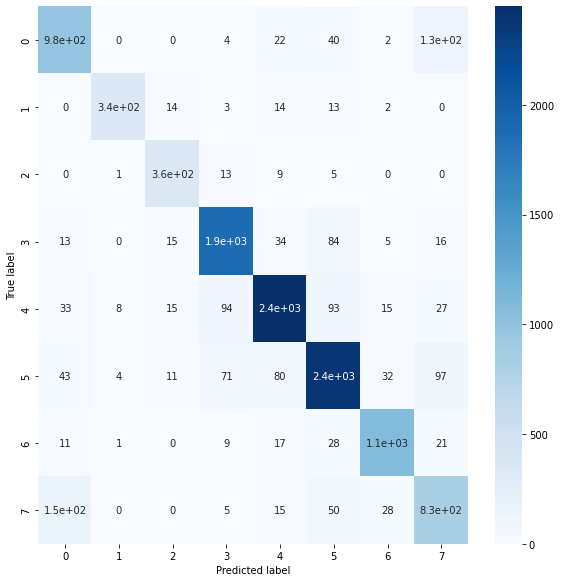

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()